# DATA 606 - Capstone Project - Zach Vance

In this file I take the cleaned data and query it to create visualizations to help guide us to the answers we are looking for from EDA analysis.

In [1]:
# imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, DoubleType, IntegerType, DateType
from pandas_profiling import ProfileReport
import pandas as pd
import pyspark.sql.functions as f

In [2]:
# Create the spark session and context.
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
# Create the schema with the column names, type, and nullable as true or false
schema = StructType([ \
    StructField("index", IntegerType(), True), \
    StructField("MLSNumber", StringType(), True), \
    StructField("DOM", IntegerType(), True), \
    StructField("CDOM", IntegerType(), True), \
    StructField("ListDate", StringType(), True), \
    StructField("AgreementOfSaleSignedLeaseDate", StringType(), True), \
    StructField("OffMarketDate", StringType(), True), \
    StructField("SettledDate", StringType(), True), \
    StructField("OriginalPrice", StringType(), True), \
    StructField("ListPrice", StringType(), True), \
    StructField("SoldPrice", StringType(), True), \
    StructField("StreetNumber", IntegerType(), True), \
    StructField("StreetDirection", StringType(), True), \
    StructField("StreetName", StringType(), True), \
    StructField("UnitNumber", IntegerType(), False), \
    StructField("City", StringType(), True), \
    StructField("ZipCode", IntegerType(), True), \
    StructField("County", StringType(), True), \
    StructField("Subdivision", StringType(), True), \
    StructField("ListAgentName", StringType(), True), \
    StructField("ListAgentCode", IntegerType(), True), \
    StructField("ListOfficeName", StringType(), True), \
    StructField("ListOfficeCode", StringType(), True), \
    StructField("SellingAgent", StringType(), True), \
    StructField("SellingAgentCode", IntegerType(), True), \
    StructField("SellingOfficeName", StringType(), True), \
    StructField("SellingOfficeCode", StringType(), True), \
    StructField("SellerConcessionsAmount", StringType(), True), \
    StructField("FinalFinancing", StringType(), True), \
    StructField("FinalShortSale", StringType(), True), \
    StructField("FinalThirdPartyApproval", StringType(), True), \
    StructField("FinalBankOwned", StringType(), True), \
    StructField("TaxAnnualTotal", IntegerType(), True), \
    StructField("TaxYear", IntegerType(), True), \
    StructField("AcresTotal", DoubleType(), True), \
    StructField("LandUseCode", IntegerType(), True), \
    StructField("Ownership", StringType(), True), \
    StructField("SeniorCommunity", StringType(), False), \
    StructField("CondoCoopAssoc", StringType(), True), \
    StructField("HOA", StringType(), True), \
    StructField("OneTimeAssociationFee", StringType(), True), \
    StructField("AssociationFee", IntegerType(), True), \
    StructField("AssociationFeeFrequency", StringType(), True), \
    StructField("Age", IntegerType(), True), \
    StructField("InteriorSqFt", IntegerType(), True), \
    StructField("PropertyCondition", StringType(), True), \
    StructField("Bedrooms", IntegerType(), True), \
    StructField("BathsFull", IntegerType(), True), \
    StructField("BathsHalf", IntegerType(), True), \
    StructField("Design", StringType(), True), \
    StructField("Style", StringType(), True), \
    StructField("NumberofStories", StringType(), True), \
    StructField("FloorNumber", IntegerType(), True), \
    StructField("Basement", StringType(), True), \
    StructField("GarageSpaces", IntegerType(), True), \
    StructField("Fireplace", StringType(), True), \
    StructField("Laundry", StringType(), True), \
    StructField("OtherRooms", StringType(), True), \
    StructField("RoomCount", IntegerType(), True), \
    StructField("CentralAir", StringType(), True), \
    StructField("Waterfront", StringType(), True), \
    StructField("NewConstruction", StringType(), True), \
    StructField("ModelName", StringType(), True), \
    StructField("BuyerBrokerCompensation", DoubleType(), True), \
    StructField("SubAgentCompensation", DoubleType(), True), \
    StructField("TransactionBrokerCompensation", DoubleType(), True), \
    StructField("OriginatingMLS", StringType(), True), \
    StructField("AboveGradeSqFt", IntegerType(), True), \
    StructField("BelowGradeSqFt", IntegerType(), True), \
    StructField("HomeBuilt", StringType(), True), \
    StructField("BasementFootprintPct", DoubleType(), True), \
    StructField("BasementFinishedPct", DoubleType(), True)
  ])

In [4]:
# Read in the appended data
df = spark.read.csv("../CleanedData/cleaned_data.csv", sep=",", schema=schema, header=True)

In [5]:
# Convert the columns that came in as strings using dollars to integers
df = df.withColumn('OriginalPrice', f.regexp_replace('OriginalPrice', '[$,]', '').cast('integer'))
df = df.withColumn('ListPrice', f.regexp_replace('ListPrice', '[$,]', '').cast('integer'))
df = df.withColumn('SoldPrice', f.regexp_replace('SoldPrice', '[$,]', '').cast('integer'))
df = df.withColumn('SellerConcessionsAmount', f.regexp_replace('SellerConcessionsAmount', '[$,]', '').cast('integer'))


In [6]:
# Verify the count
df.count()

90758

In [7]:
# Cache the dataframe
dfCache = df.cache()

In [8]:
# Run the pandas profile report for initial exploration
profile = ProfileReport(dfCache.toPandas(), title="Pandas Profiling Report", minimal=True)
profile

In [9]:
# Write the output to the reports folder.
profile.to_file(output_file="../Reports/cleaned_data_pandas_profile.html")

In [10]:
# Verify the unique 4 counties exist - Anne Arundel, Baltimore, Harford, Howard
# Just a test of the agg function
dfCache.agg(f.countDistinct('County')).show()

+-------------+
|count(County)|
+-------------+
|            4|
+-------------+



In [11]:
# Use SQL to query for the average price per county, per date.  Grouped by each Month's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT MONTH(to_date(SettledDate, 'M/d/y')) AS Date, County, avg(SoldPrice) as Price
FROM housing_data
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+------------------+
|Date|       County|             Price|
+----+-------------+------------------+
|  12|    HARFORDMD| 369317.3697813121|
|  12|ANNEARUNDELMD|  522959.279725917|
|  12|  BALTIMOREMD|370341.63171355496|
|  12|     HOWARDMD| 611608.2491694352|
|  11|  BALTIMOREMD|372355.39094339625|
|  11|     HOWARDMD| 605927.4270833334|
|  11|ANNEARUNDELMD|511572.12824675324|
|  11|    HARFORDMD|369408.62003968254|
|  10|     HOWARDMD|  607932.259222333|
|  10|ANNEARUNDELMD|497354.59444048465|
|  10|    HARFORDMD| 369276.2063789869|
|  10|  BALTIMOREMD|373794.95621959696|
|   9|  BALTIMOREMD| 370686.8321060383|
|   9|ANNEARUNDELMD|  507577.040954416|
|   9|     HOWARDMD| 619170.7897111913|
|   9|    HARFORDMD| 378948.9650485437|
|   8|     HOWARDMD| 625300.9076127125|
|   8|ANNEARUNDELMD| 512796.6229613048|
|   8|  BALTIMOREMD| 381113.1599388379|
|   8|    HARFORDMD| 388684.0317337461|
+----+-------------+------------------+
only showing top 20 rows



In [12]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


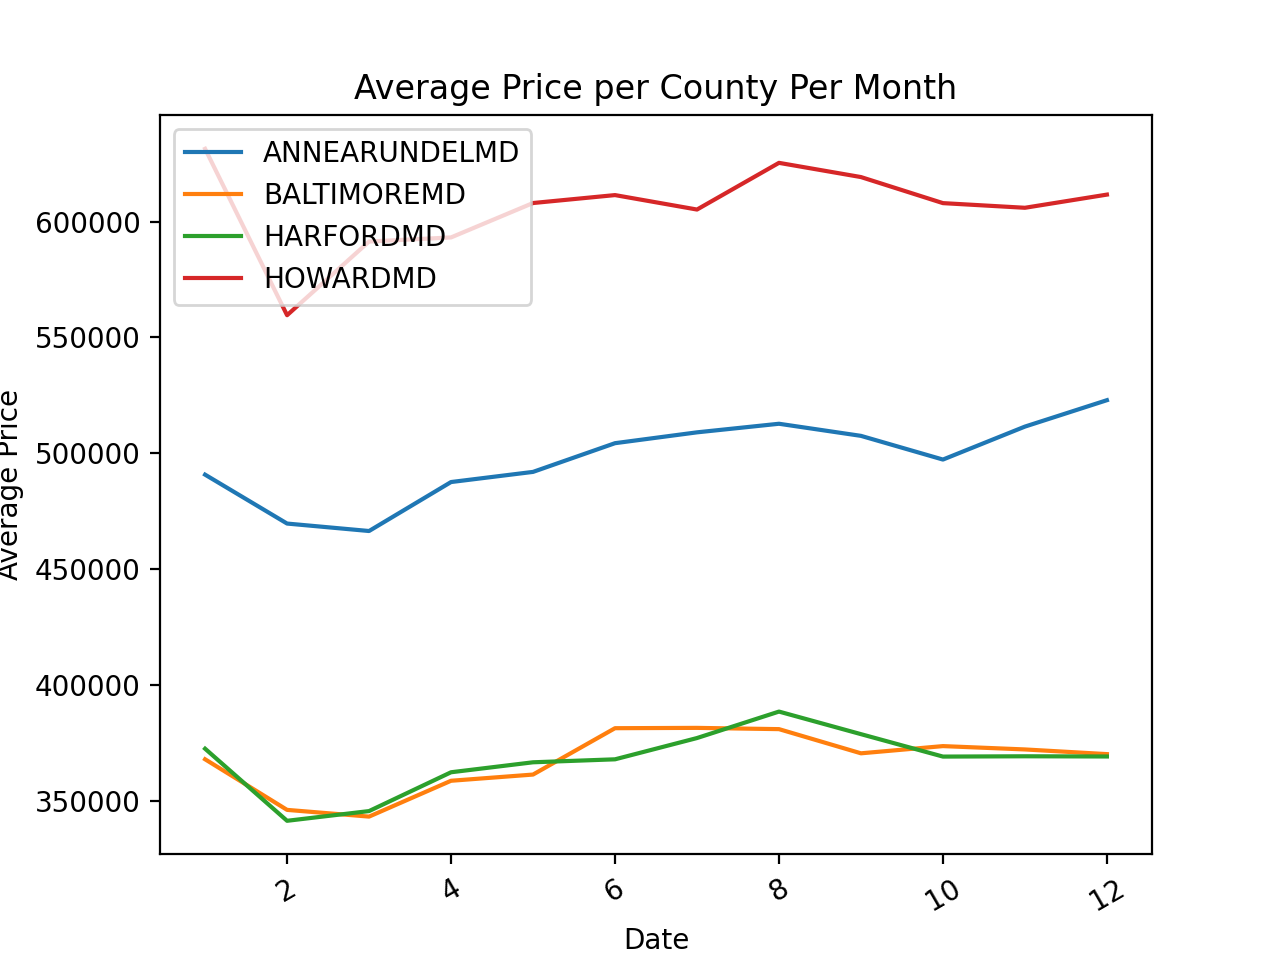

<function matplotlib.pyplot.show(block=None)>

In [13]:
%matplotlib notebook

# Plot the price by date for each County on the same chart for comparison.
by_label = pdf.groupby('County')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per County Per Month")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.savefig("../Images/PricePerCountyPerMonth.png",bbox_inches='tight')
plt.show


From the above chart we can easily see that Howard county is the most expensive, followed by Anne Arundel, then by both Harford and Baltimore being similar price levels.  Interestingly, the price movements up and down seem to follow the same trend over the course of the year.  As the proce in Howard goes up towards the summer months, so does the price in Anne Arundel and the other counties, at about the same rate as well.

In [14]:
# Use SQL to query for the average price per county, per date.  Grouped by each year's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, avg(SoldPrice) as Price
FROM housing_data
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+------------------+
|Date|       County|             Price|
+----+-------------+------------------+
|  22|    HARFORDMD| 434501.1098265896|
|  22|  BALTIMOREMD|446397.42052313883|
|  22|ANNEARUNDELMD| 545064.7616580311|
|  22|     HOWARDMD| 688254.9925373135|
|  21|     HOWARDMD| 698511.9186172128|
|  21|    HARFORDMD|432373.33827893174|
|  21|ANNEARUNDELMD| 576423.7605748373|
|  21|  BALTIMOREMD|425179.93201634876|
|  20|     HOWARDMD| 616681.3457798522|
|  20|    HARFORDMD| 383072.2459379616|
|  20|  BALTIMOREMD|382289.84152208775|
|  20|ANNEARUNDELMD| 521416.9277604314|
|  19|     HOWARDMD| 575447.4572008114|
|  19|    HARFORDMD| 351071.7452563585|
|  19|ANNEARUNDELMD| 471692.1456857695|
|  19|  BALTIMOREMD| 348146.2355527638|
|  18|  BALTIMOREMD|  339546.158598207|
|  18|ANNEARUNDELMD|462082.06363949087|
|  18|     HOWARDMD|  570454.003773585|
|  18|    HARFORDMD|333621.37216404884|
+----+-------------+------------------+
only showing top 20 rows



In [15]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


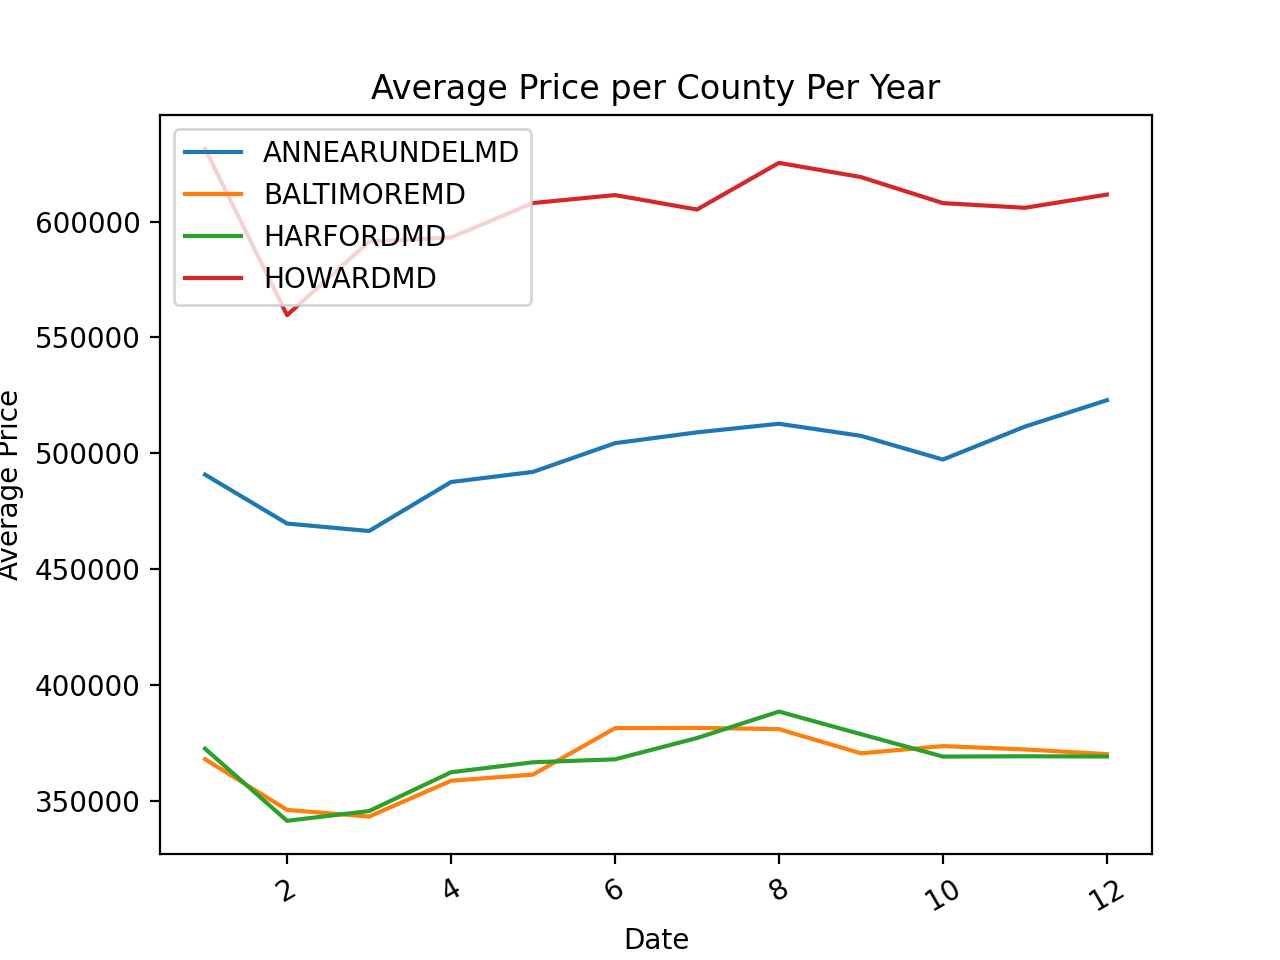

<function matplotlib.pyplot.show(block=None)>

In [14]:
%matplotlib notebook

# Plot the price by date (year) for each County on the same chart for comparison.
by_label = pdf.groupby('County')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per County Per Year")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.savefig("../Images/PricePerCountyPerYear.png",bbox_inches='tight')
plt.show



From the above chart we can easily see the upward trend in the cost of house prices over the years.  We see again the same ordering of price levels of the 4 counties and increases at similar rates.  Home prices look to have peaked in 2021 and have so far leveled off or decreased slightly so far into 2022.

In [17]:
# Use SQL to query for the average price per county, per date.  Grouped by each year's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, City, avg(SoldPrice) as Price
FROM housing_data
WHERE County = 'HARFORDMD'
GROUP BY Date, City
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+--------------+------------------+
|Date|          City|             Price|
+----+--------------+------------------+
|  22|   Forest Hill| 572658.3333333334|
|  22|       Bel Air| 530004.6511627907|
|  22|Havre De Grace|        347811.125|
|  22|      Abingdon|409058.82352941175|
|  22|      Edgewood| 269874.6923076923|
|  22|    Pylesville| 533966.6666666666|
|  22|   Churchville|          460400.0|
|  22|        Street| 459309.0909090909|
|  22|       Baldwin|          622500.0|
|  22| Jarrettsville| 435190.3333333333|
|  22|      Aberdeen| 332914.2380952381|
|  22|      Fallston|          512500.0|
|  22|       Belcamp|          277000.0|
|  22|    Darlington| 343166.6666666667|
|  22|         Joppa|        394943.875|
|  21|       Bel Air|475981.24828532233|
|  21|    White Hall|521586.95652173914|
|  21|      Fallston| 553504.8604651163|
|  21|Havre De Grace| 400942.9246861925|
|  21|       Belcamp| 304412.2727272727|
+----+--------------+------------------+
only showing top

In [18]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


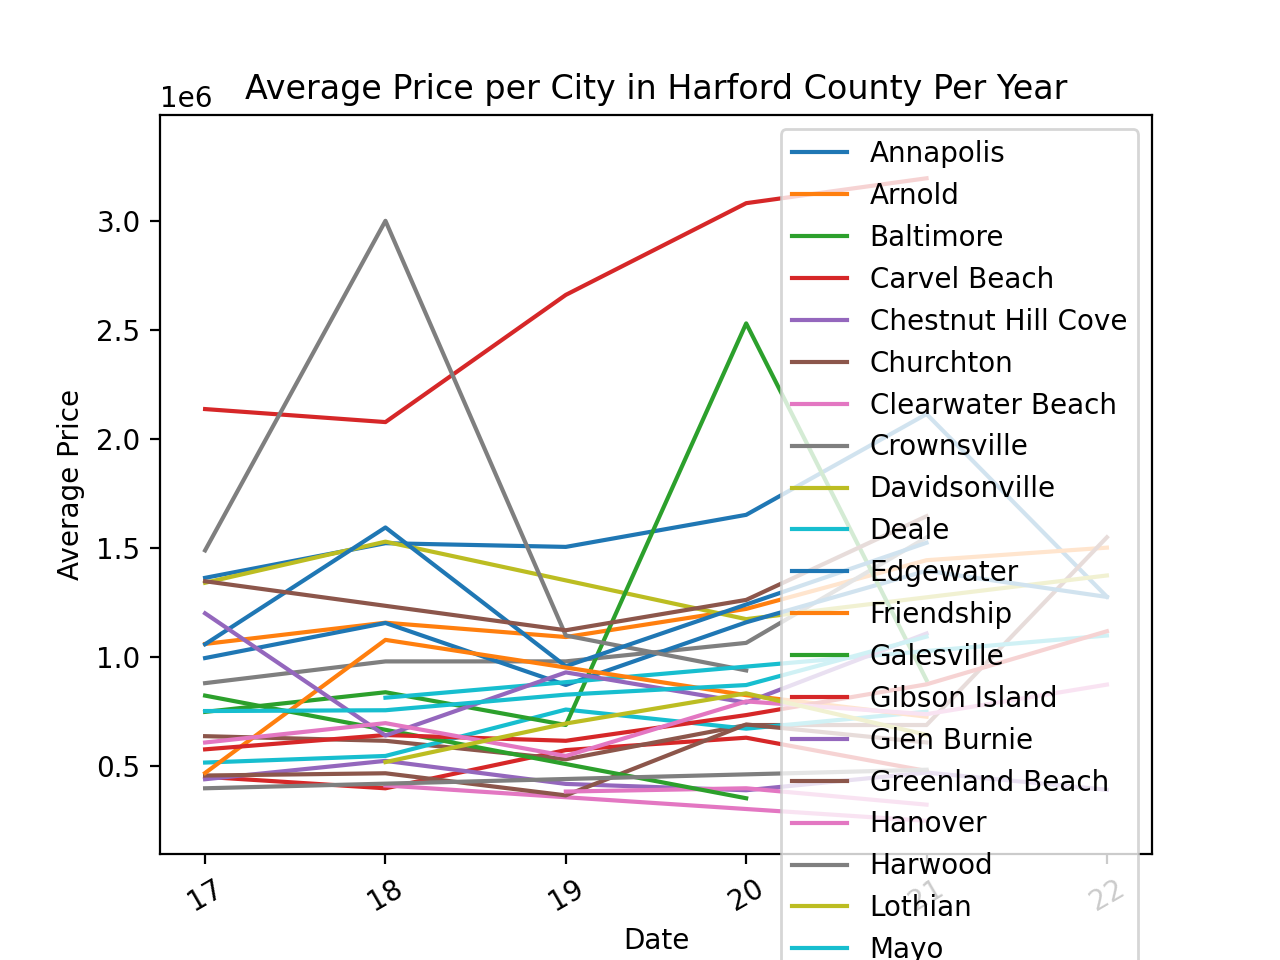

<function matplotlib.pyplot.show(block=None)>

In [19]:
%matplotlib notebook

# Plot the price by date (year) for each City in Harford County on the same chart for comparison.
by_label = pdf.groupby('City')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per City in Harford County Per Year")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.savefig("../Images/PricePerCityInHarfordPerYear.png",bbox_inches='tight')
plt.show




Breaking the data down even further, we can query by city inside of each County, it is easier to graph on a chart like this if we look more specifically at certain cities we are interested in as there are just too many to put on one chart and for it to be legible.  Another concern with this is that when the data is at a level this low and we are usign the average, an outlier has more potential to throw off the results.  For instance, prices in Churchville look to have skyrockets going into 2021, that could be due to a couple outliers or there could be another reason - and that is something to look into further.

In [15]:
# Use SQL to query for the average price per county over time for Anne Arundel Waterfront by City

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, City, avg(SoldPrice) as Price
FROM housing_data
WHERE County = 'ANNEARUNDELMD' AND Waterfront = 'Yes'
GROUP BY Date, City
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+------------------+
|Date|         City|             Price|
+----+-------------+------------------+
|  22|   Shady Side|          875000.0|
|  22|    Annapolis|         1277500.0|
|  22|    Edgewater|1276666.6666666667|
|  22|       Arnold|         1502500.0|
|  22|    Churchton|         1550000.0|
|  22|  Glen Burnie| 393333.3333333333|
|  22|         Mayo|         1100000.0|
|  22|     Pasadena|         1119470.0|
|  22|Davidsonville|         1375000.0|
|  21|        Deale|          751000.0|
|  21| Severna Park|1646705.8823529412|
|  21|    Churchton| 689883.3333333334|
|  21|         Riva|1109246.7777777778|
|  21|   West River|         1095000.0|
|  21|  Crownsville|1549026.3157894737|
|  21|   Galesville|         895397.75|
|  21|  Glen Burnie|471977.77777777775|
|  21|      Hanover|          325000.0|
|  21|   Shady Side| 739474.8947368421|
|  21| Stoney Beach|          485000.0|
+----+-------------+------------------+
only showing top 20 rows



In [16]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


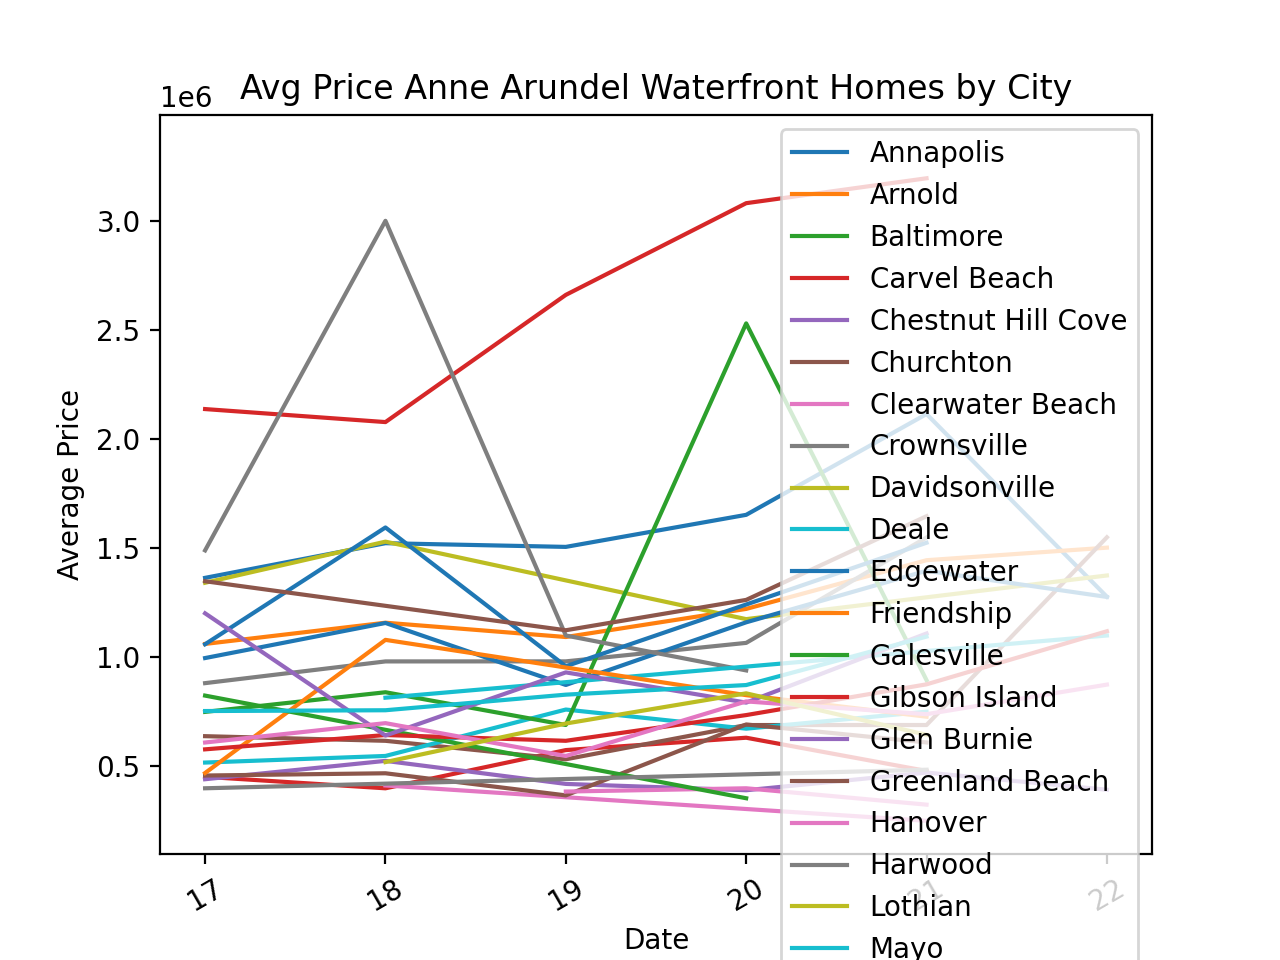

<function matplotlib.pyplot.show(block=None)>

In [20]:
%matplotlib notebook

# Plot the price by date for each City in Anne Arundel County on the same chart for comparison.
by_label = pdf.groupby('City')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Avg Price Anne Arundel Waterfront Homes by City")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.savefig("../Images/PricePerCityInAnneArundelWaterfrontPerYear.png",bbox_inches='tight')
plt.show





With being interested in waterfront property myself in Anne Arundel county it is helpful for me to see where the most affordable waterfront property is, and how prices for it have trended over the last 5 years.  Hanover looks to be the most affordable, and to have stayed relatively flat over the years, which may be good for a lower price purchasing the land, but also hinders the outlook as an investment and looking to gain the most possible from appreciation of the property.

In [21]:
# Use SQL to query for the median number of acres per county for new construction.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, percentile_approx(AcresTotal, 0.5) as Acres
FROM housing_data
WHERE NewConstruction = 'Yes'
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+-----+
|Date|       County|Acres|
+----+-------------+-----+
|  22|ANNEARUNDELMD| 0.15|
|  22|    HARFORDMD|  0.5|
|  22|  BALTIMOREMD| 0.18|
|  22|     HOWARDMD|  1.0|
|  21|     HOWARDMD|  0.3|
|  21|ANNEARUNDELMD| 0.16|
|  21|  BALTIMOREMD| 0.18|
|  21|    HARFORDMD| 0.21|
|  20|  BALTIMOREMD|  0.2|
|  20|    HARFORDMD| 0.23|
|  20|ANNEARUNDELMD| 0.16|
|  20|     HOWARDMD|  0.2|
|  19|    HARFORDMD| 0.19|
|  19|     HOWARDMD| 0.29|
|  19|  BALTIMOREMD|  0.2|
|  19|ANNEARUNDELMD| 0.15|
|  18|  BALTIMOREMD| 0.21|
|  18|ANNEARUNDELMD| 0.18|
|  18|     HOWARDMD| 0.25|
|  18|    HARFORDMD| 0.25|
+----+-------------+-----+
only showing top 20 rows



In [22]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


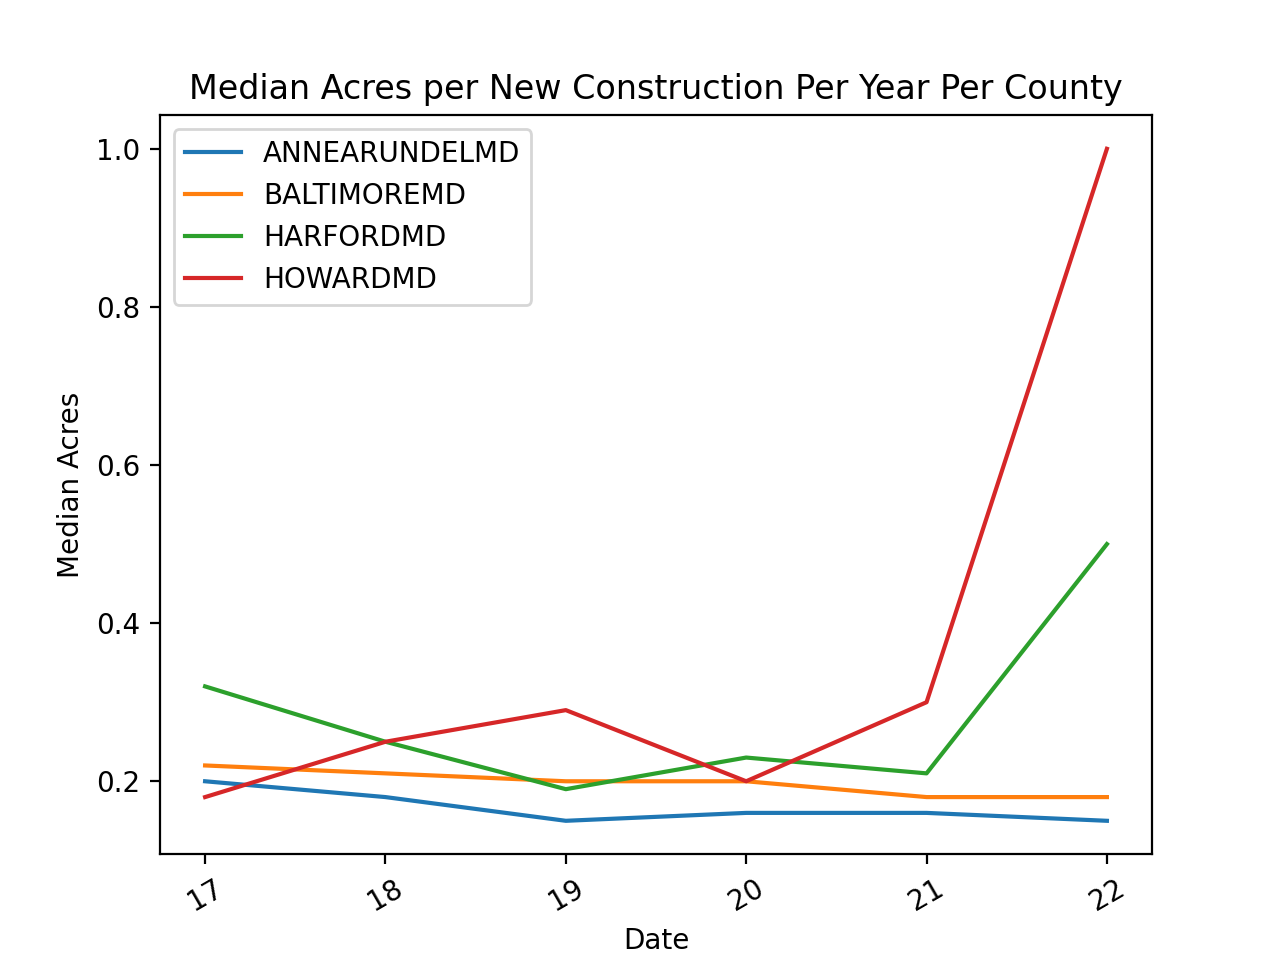

<function matplotlib.pyplot.show(block=None)>

In [23]:
%matplotlib notebook

# Plot the median number of acres for new construction by county over time.
by_label = pdf.groupby('County')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Acres'], label=name)

plt.title("Median Acres per New Construction Per Year Per County")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Median Acres")
plt.legend()
plt.savefig("../Images/medianAcresPerNewConstructionPerCounty.png",bbox_inches='tight')
plt.show


In the above chart we see that there has been a sligh downward trend in the size of new construction lots, more steadily for Anne Arundel and Baltimore counties.  The median in those counties has stayed in the 0.2 acre range, and that is already really small so it makes sense that the downward trend has only been slight - it is tough to get much smaller than that.  Interestingly, Howard, which we saw as the most expensive, and Harford, which we saw as the least expensive alongside Baltimore County look to have their new construction lot sizes be slightly larger, and the downward trend is not as clear or evident for those counties.  Howard and Harford counties have more land, so it will be interesting to see where the price difference between the two comes from whether it be mainly rooted in location or if homes in Howard tend to be larger than that of Harford.  For Howard, in 2022, there have only been 5 new construction home sales, 3 of which were 1 acre lots, the other 2 being 0.14 and 0.24 acres, so I'd expect that as we get further into 2022 that number come down.  Harford and Howard also have a lesser volume of homes than Anne Arundel and Baltimore counties, making their numbers less consistent.

In [25]:
# Use SQL to query for the median sold price for waterfront homes per county.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, Waterfront, percentile_approx(SoldPrice, 0.5) as Price
FROM housing_data
GROUP BY Date, County, Waterfront
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+----------+-------+
|Date|       County|Waterfront|  Price|
+----+-------------+----------+-------+
|  22|  BALTIMOREMD|       Yes| 350000|
|  22|ANNEARUNDELMD|       Yes|1050000|
|  22|  BALTIMOREMD|        No| 360000|
|  22|ANNEARUNDELMD|        No| 440000|
|  22|     HOWARDMD|        No| 627500|
|  22|    HARFORDMD|        No| 425000|
|  22|    HARFORDMD|       Yes| 500000|
|  21|  BALTIMOREMD|        No| 355000|
|  21|    HARFORDMD|       Yes| 479000|
|  21|    HARFORDMD|        No| 410000|
|  21|ANNEARUNDELMD|       Yes|1096800|
|  21|     HOWARDMD|        No| 635900|
|  21|     HOWARDMD|       Yes| 900000|
|  21|  BALTIMOREMD|       Yes| 490000|
|  21|ANNEARUNDELMD|        No| 469000|
|  20|     HOWARDMD|       Yes| 912000|
|  20|ANNEARUNDELMD|       Yes| 905000|
|  20|ANNEARUNDELMD|        No| 427000|
|  20|  BALTIMOREMD|       Yes| 449900|
|  20|  BALTIMOREMD|        No| 322500|
+----+-------------+----------+-------+
only showing top 20 rows



In [26]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


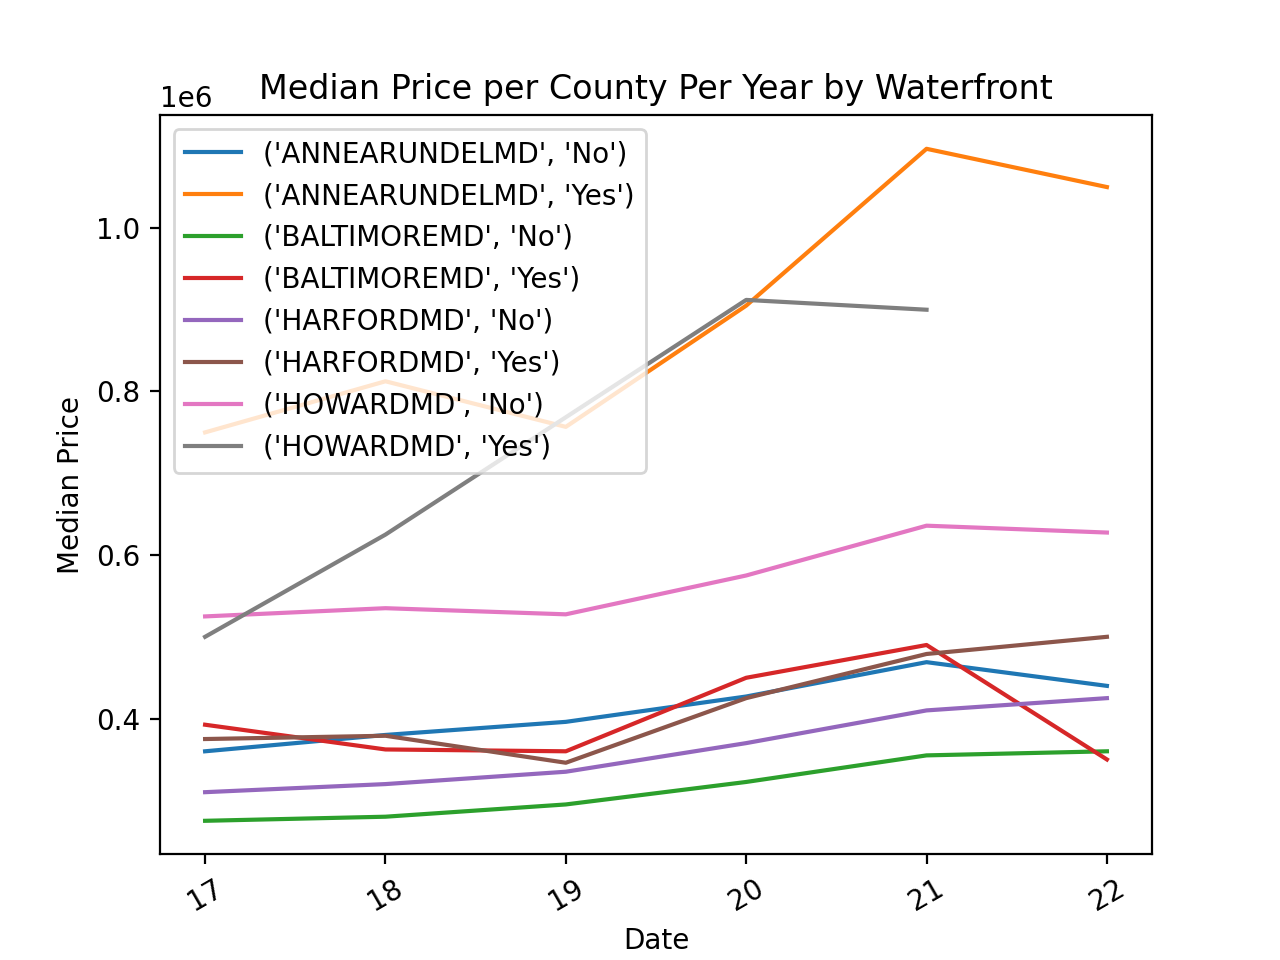

<function matplotlib.pyplot.show(block=None)>

In [27]:
%matplotlib notebook

# Plot the median price for waterfront vs non waterfront homes sold over time per county.
by_label = pdf.groupby(['County', 'Waterfront'])
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Median Price per County Per Year by Waterfront")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Median Price")
plt.legend()
plt.savefig("../Images/medianPricePerWaterfrontPerCounty.png",bbox_inches='tight')
plt.show



Looking at the above chart, it is clear that Anne Arundel County waterfront homes look to have increased pretty dramatically from 2019 to 2021.  When looking at 2022, I would engourage to see it as valuable information but at the same time not to the same extent as the other years as there is not as much data for it only two months into the year (Howard hasn't had any waterfront home sales yet this year).  In Anne Arundel county, the price difference between the medians of waterfront and non waterfront is also pretty significant with the median for non waterfront being down around 400k and waterfront up over 1 million.  The cheapest is non waterfront in Baltimore county, and the difference between waterfront and non waterfront in Baltimore county is not as significant.  Waterfront is consistently more expensive than non waterfront in all of the counties, but to different degrees.

In [28]:
# Use SQL to query for the median price of new construction per county over time.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, NewConstruction, percentile_approx(SoldPrice, 0.5) as Price
FROM housing_data
GROUP BY Date, County, NewConstruction
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+---------------+------+
|Date|       County|NewConstruction| Price|
+----+-------------+---------------+------+
|  22|ANNEARUNDELMD|            Yes|688219|
|  22|  BALTIMOREMD|             No|350000|
|  22|ANNEARUNDELMD|             No|440000|
|  22|     HOWARDMD|            Yes|928499|
|  22|  BALTIMOREMD|            Yes|639887|
|  22|     HOWARDMD|             No|620000|
|  22|    HARFORDMD|             No|425000|
|  22|    HARFORDMD|            Yes|467471|
|  21|    HARFORDMD|             No|400000|
|  21|     HOWARDMD|            Yes|995988|
|  21|    HARFORDMD|            Yes|531617|
|  21|  BALTIMOREMD|            Yes|590315|
|  21|  BALTIMOREMD|             No|352000|
|  21|     HOWARDMD|             No|630000|
|  21|ANNEARUNDELMD|            Yes|678482|
|  21|ANNEARUNDELMD|             No|465000|
|  20|ANNEARUNDELMD|            Yes|593053|
|  20|     HOWARDMD|            Yes|759960|
|  20|  BALTIMOREMD|             No|320000|
|  20|    HARFORDMD|            

In [29]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


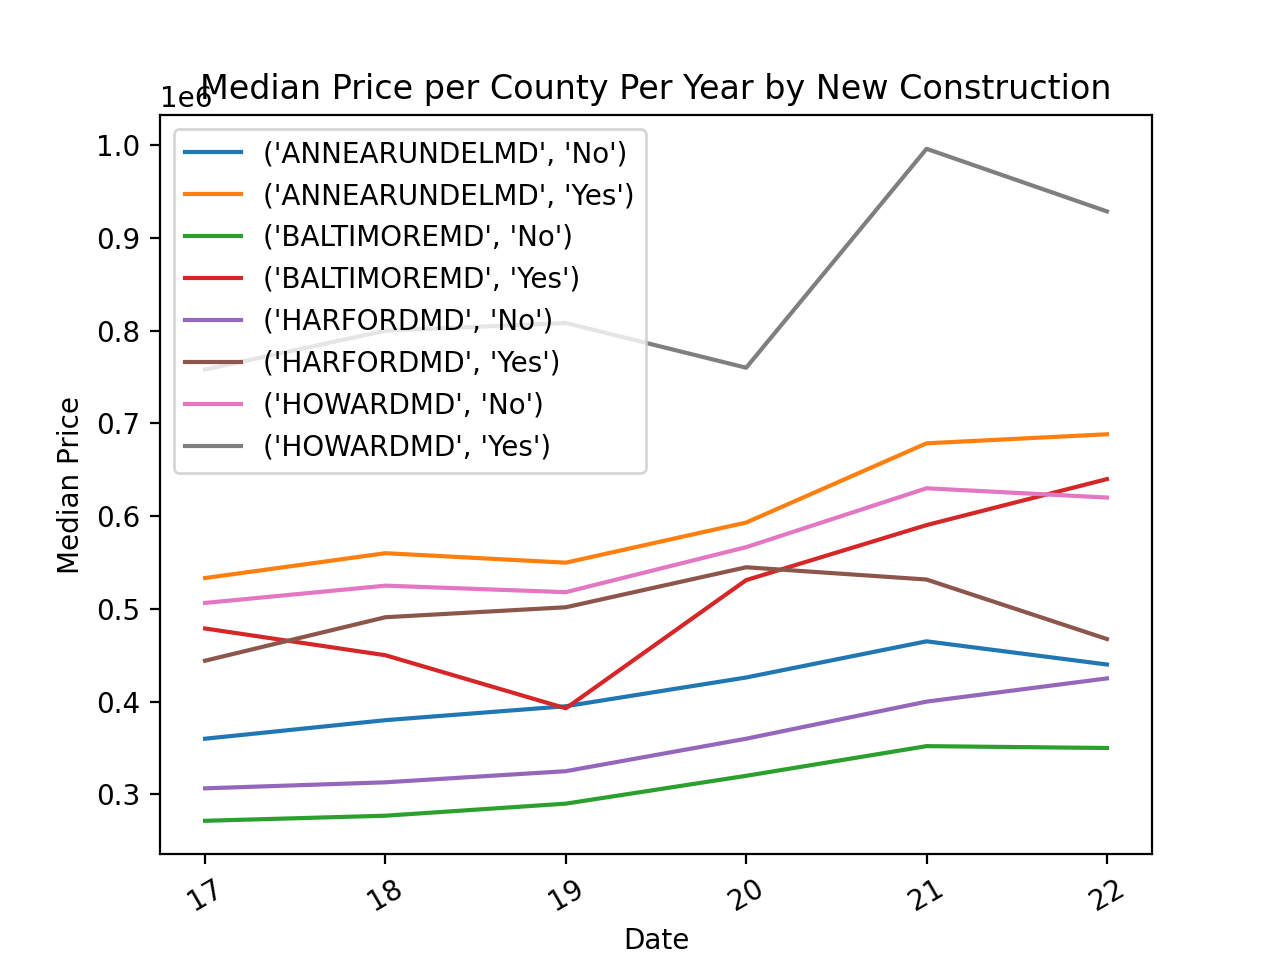

<function matplotlib.pyplot.show(block=None)>

In [42]:
%matplotlib notebook

# Plot the price by date for each City in Anne Arundel County on the same chart for comparison.
by_label = pdf.groupby(['County', 'NewConstruction'])
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Median Price per County Per Year by New Construction")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Median Price")
plt.legend()
plt.savefig("../Images/medianPricePerNewConstructionPerCounty.png",bbox_inches='tight')
plt.show


Here we see that new construction is consistently more expensive than non new construction in each and every county, to different degrees in each county.  Again Baltimore, non new construction shows as the cheapest option and we see Howard new construction as the most expensive option.  This is consistent with the overall average prices we saw per county earlier in the analysis and the same general increase in prices across the board.

In [30]:
# Use SQL to query for average price difference of sold - list price over time.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCacheNew = dfCache
# Create a new column of the price difference being sold - list price.
dfCacheNew = dfCacheNew.withColumn('PriceDiff', ( dfCacheNew['SoldPrice'] - dfCacheNew['ListPrice'] ) )
dfCacheNew.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, avg(PriceDiff) as PriceDiff
FROM housing_data
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+-------------------+
|Date|       County|          PriceDiff|
+----+-------------+-------------------+
|  22|    HARFORDMD|  6863.450867052024|
|  22|  BALTIMOREMD| 1476.2997987927565|
|  22|     HOWARDMD| 12537.664179104477|
|  22|ANNEARUNDELMD| -2880.339378238342|
|  21|ANNEARUNDELMD| 2473.9412960954446|
|  21|  BALTIMOREMD|   2893.14931880109|
|  21|     HOWARDMD|  13291.93086064098|
|  21|    HARFORDMD| 3901.5701038575667|
|  20|  BALTIMOREMD|-3640.4400058317538|
|  20|    HARFORDMD| -1725.251846381093|
|  20|     HOWARDMD|-2932.8121353558927|
|  20|ANNEARUNDELMD| -5699.560317910871|
|  19|     HOWARDMD| -5922.202839756592|
|  19|ANNEARUNDELMD| -8445.739858338698|
|  19|  BALTIMOREMD| -5672.456344221106|
|  19|    HARFORDMD|-2922.9689140088817|
|  18|ANNEARUNDELMD|-10567.159786721706|
|  18|     HOWARDMD|  -6277.45786163522|
|  18|    HARFORDMD|-3155.5340314136124|
|  18|  BALTIMOREMD| -7573.312306438468|
+----+-------------+-------------------+
only showing top

In [31]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


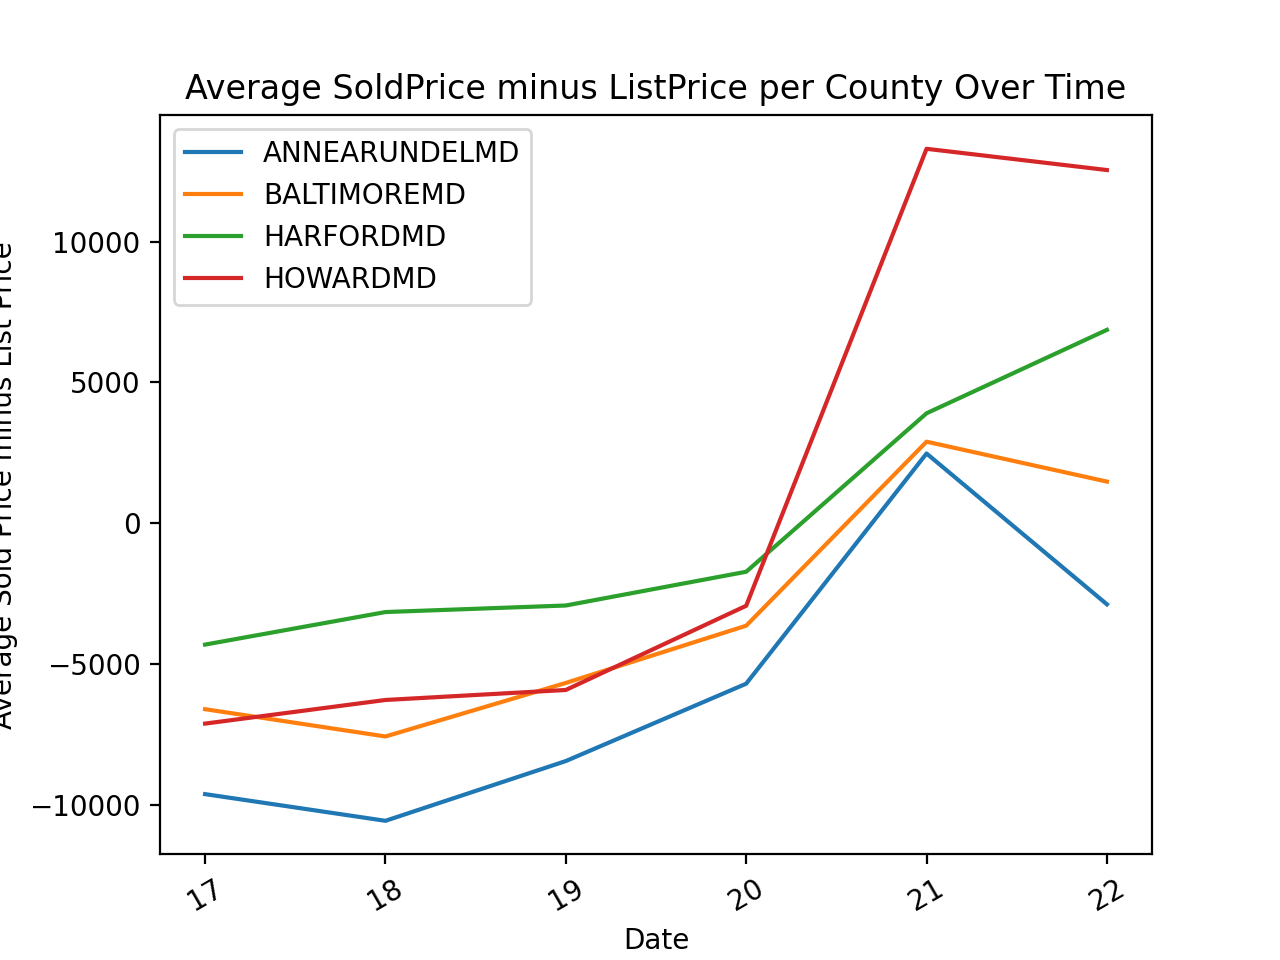

<function matplotlib.pyplot.show(block=None)>

In [32]:
%matplotlib notebook

# Plot the price by date for each City in Anne Arundel County on the same chart for comparison.
by_label = pdf.groupby(['County'])
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['PriceDiff'], label=name)

plt.title("Average SoldPrice minus ListPrice per County Over Time")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Sold Price minus List Price")
plt.legend()
plt.savefig("../Images/avgSoldPriceMinusListPrice.png",bbox_inches='tight')
plt.show



Looking at the above figure we see that the housing market had become much more of a sellers market as of recently.  Up until 2020 homes were selling for under their list price, then with markets becoming more competitive in 2020 with the development of the COVID-19 pandemic, residential homes have been selling at or above their list price.  So, clearly, home price is dependent on more than just the features of the house - it depends on world events and market fluctuation.

In [33]:
# Use SQL to query for the count of new construction homes per county over time.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, count(1) as Count
FROM housing_data
WHERE NewConstruction = 'Yes'
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)

output.show()

# Data is shown to ensure it looks correct.

+----+-------------+-----+
|Date|       County|Count|
+----+-------------+-----+
|  22|    HARFORDMD|    4|
|  22|  BALTIMOREMD|   21|
|  22|     HOWARDMD|    5|
|  22|ANNEARUNDELMD|   26|
|  21|ANNEARUNDELMD|  511|
|  21|     HOWARDMD|  101|
|  21|    HARFORDMD|  130|
|  21|  BALTIMOREMD|  227|
|  20|     HOWARDMD|  117|
|  20|    HARFORDMD|  200|
|  20|  BALTIMOREMD|  226|
|  20|ANNEARUNDELMD|  561|
|  19|    HARFORDMD|  140|
|  19|  BALTIMOREMD|  257|
|  19|     HOWARDMD|  142|
|  19|ANNEARUNDELMD|  442|
|  18|  BALTIMOREMD|  236|
|  18|ANNEARUNDELMD|  410|
|  18|     HOWARDMD|  157|
|  18|    HARFORDMD|  120|
+----+-------------+-----+
only showing top 20 rows



<IPython.core.display.Javascript object>


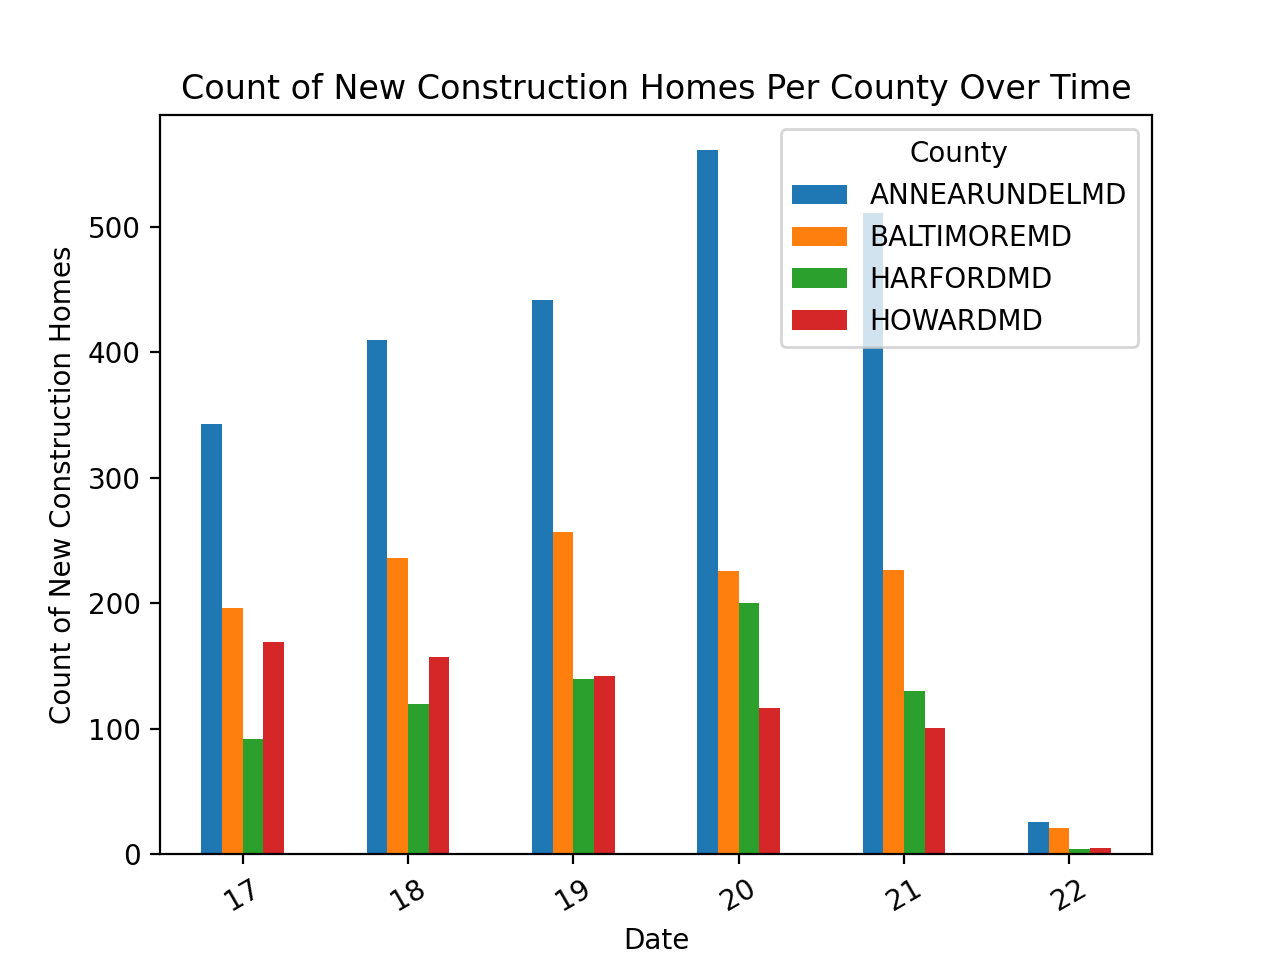

In [34]:
%matplotlib notebook
df = output.toPandas()

df.pivot("Date", "County", "Count").plot(kind='bar')
plt.title("Count of New Construction Homes Per County Over Time")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Count of New Construction Homes")
plt.savefig("../Images/countOfNewConstructionPerCounty.png",bbox_inches='tight')
plt.show()


Comparatively, the count of new construction homes looks to be favored in Anne Arundel - it has the most new construction homes and the counts of new construction there have increased over the years.  The least amount is between Harford and Howard.  New construction decreased slightly across the board in 2021 in the midst of the COVID-19 pandemic and has consistently decreased gradually in Howard county.  2022 is low again because it is not a full years worth of data.

In [35]:
# Use SQL to query for the count of waterfront homes per county over time.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, count(1) as Count
FROM housing_data
WHERE Waterfront = 'Yes'
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)

output.show()

# Data is shown to ensure it looks correct.

+----+-------------+-----+
|Date|       County|Count|
+----+-------------+-----+
|  22|    HARFORDMD|    3|
|  22|  BALTIMOREMD|    7|
|  22|ANNEARUNDELMD|   25|
|  21|ANNEARUNDELMD|  456|
|  21|     HOWARDMD|    2|
|  21|    HARFORDMD|   28|
|  21|  BALTIMOREMD|  161|
|  20|    HARFORDMD|   33|
|  20|     HOWARDMD|    2|
|  20|  BALTIMOREMD|  148|
|  20|ANNEARUNDELMD|  534|
|  19|  BALTIMOREMD|  141|
|  19|    HARFORDMD|   28|
|  19|ANNEARUNDELMD|  401|
|  18|ANNEARUNDELMD|  365|
|  18|  BALTIMOREMD|  126|
|  18|    HARFORDMD|   16|
|  18|     HOWARDMD|    3|
|  17|  BALTIMOREMD|  116|
|  17|ANNEARUNDELMD|  357|
+----+-------------+-----+
only showing top 20 rows



<IPython.core.display.Javascript object>


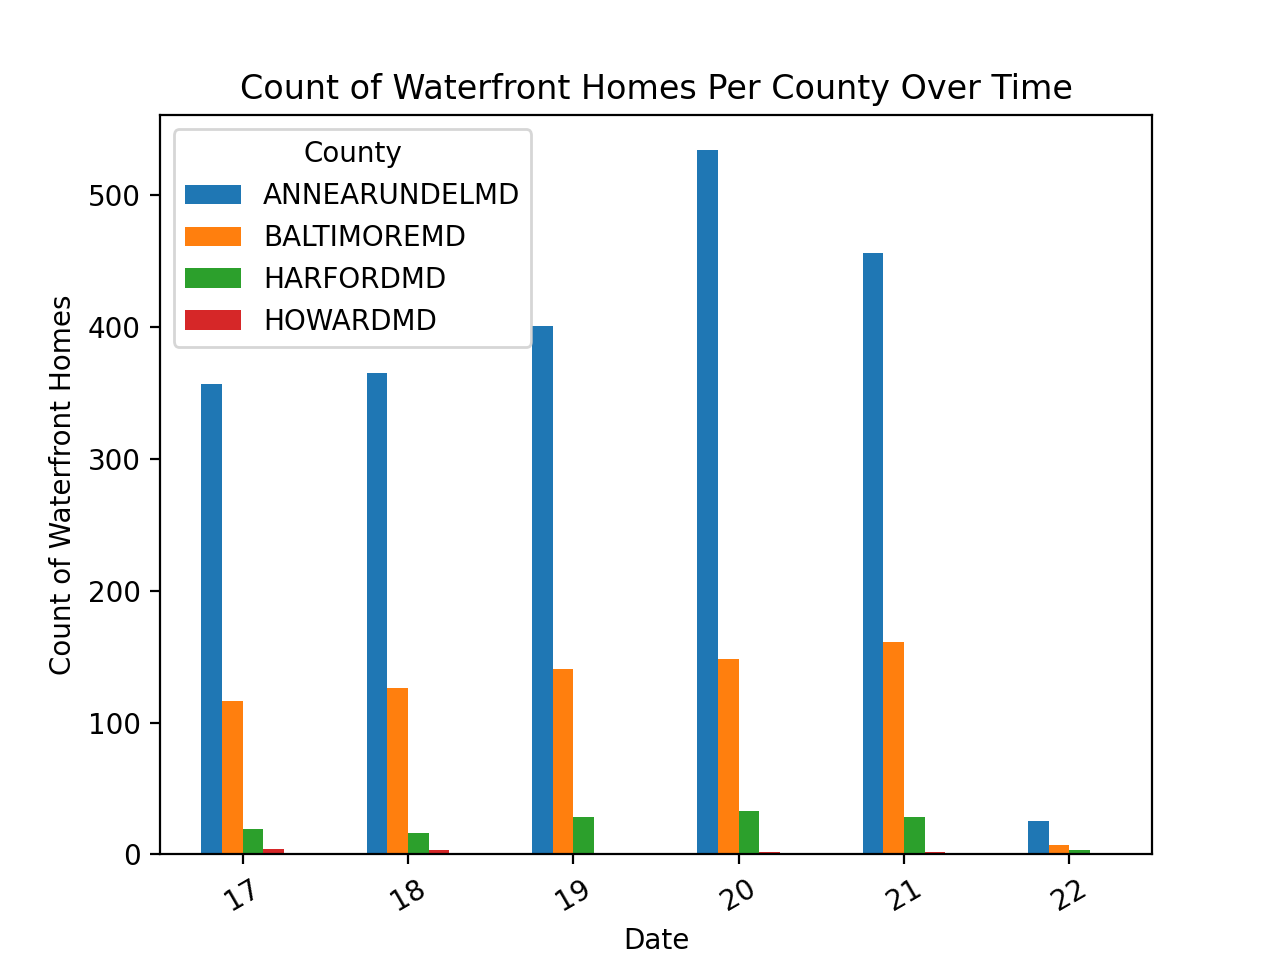

In [36]:
%matplotlib notebook
df = output.toPandas()

df.pivot("Date", "County", "Count").plot(kind='bar')
plt.title("Count of Waterfront Homes Per County Over Time")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Count of Waterfront Homes")
plt.savefig("../Images/countOfWaterfrontPerCountyOverTime.png",bbox_inches='tight')
plt.show()



From the above graphic it is clear that Anne Arundel county has way more waterfront homes than any of the other counties.  Baltimore is the next closest, Harford has a few but not many and Howard doesn't have much at all.  Interestingly, with Howard being the priciest county, the high prices in that region must not be coming from the waterfront feature and from somewhere else.

In [37]:
# Use SQL to query for the count of non waterfront homes per county over time.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, count(1) as Count
FROM housing_data
WHERE Waterfront = 'No'
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)

output.show()

# Data is shown to ensure it looks correct.

+----+-------------+-----+
|Date|       County|Count|
+----+-------------+-----+
|  22|    HARFORDMD|  170|
|  22|  BALTIMOREMD|  490|
|  22|     HOWARDMD|  134|
|  22|ANNEARUNDELMD|  361|
|  21|     HOWARDMD| 2775|
|  21|ANNEARUNDELMD| 6920|
|  21|    HARFORDMD| 2668|
|  21|  BALTIMOREMD| 7179|
|  20|     HOWARDMD| 2569|
|  20|    HARFORDMD| 2675|
|  20|  BALTIMOREMD| 6711|
|  20|ANNEARUNDELMD| 6512|
|  19|  BALTIMOREMD| 6227|
|  19|     HOWARDMD| 2465|
|  19|    HARFORDMD| 2449|
|  19|ANNEARUNDELMD| 5811|
|  18|     HOWARDMD| 2382|
|  18|    HARFORDMD| 2276|
|  18|  BALTIMOREMD| 6009|
|  18|ANNEARUNDELMD| 5449|
+----+-------------+-----+
only showing top 20 rows



<IPython.core.display.Javascript object>


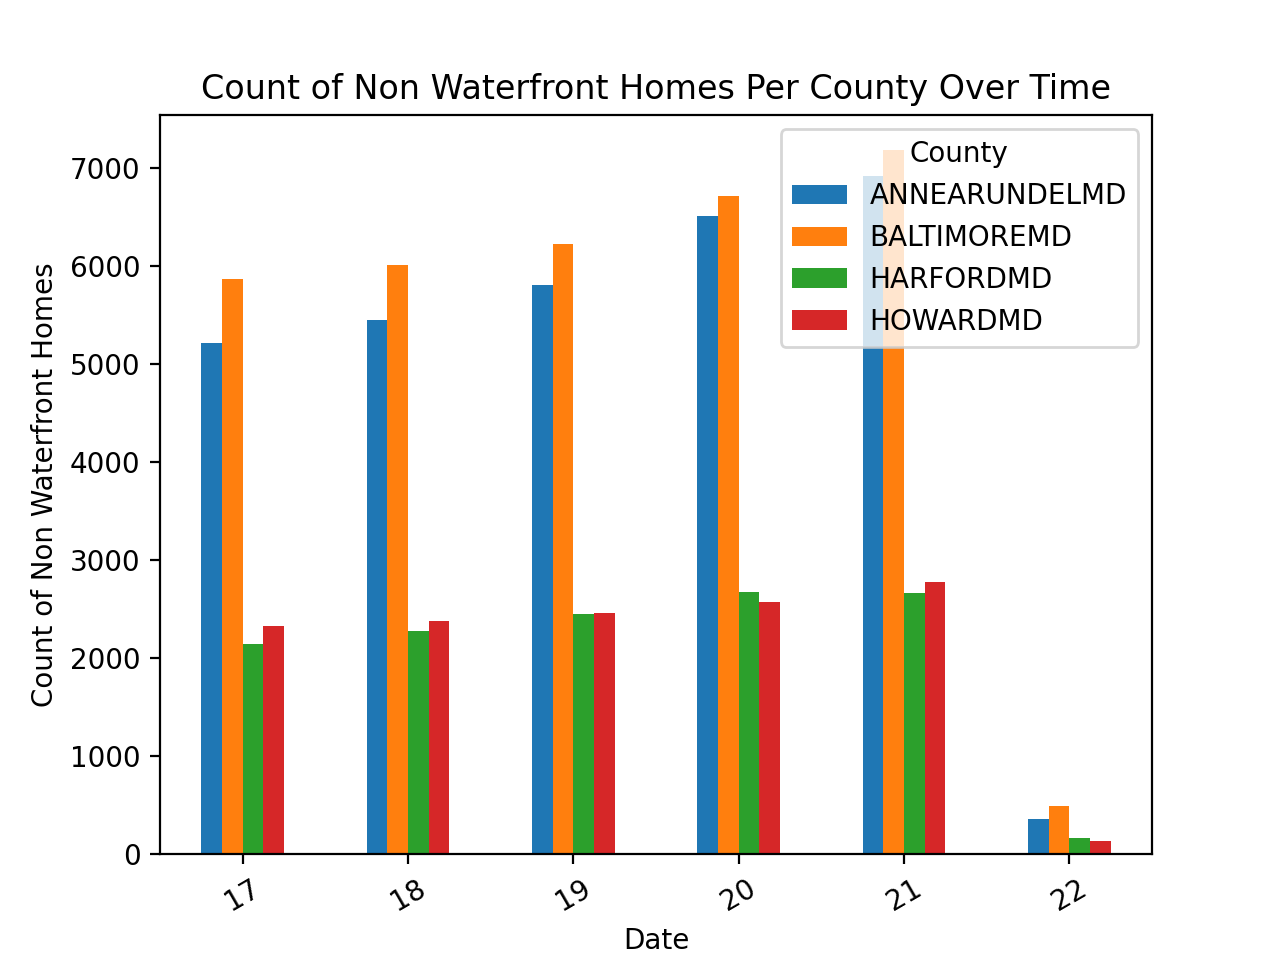

In [38]:
%matplotlib notebook
df = output.toPandas()

df.pivot("Date", "County", "Count").plot(kind='bar')
plt.title("Count of Non Waterfront Homes Per County Over Time")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Count of Non Waterfront Homes")
plt.savefig("../Images/countOfNonWaterfrontPerCountyOverTime.png",bbox_inches='tight')
plt.show()



The count of non waterfront homes has stayed pretty consistent over the years across all the counties.  With Anne Arundel and Baltimore having the most.  Anne Arundel is the largest county of the 4 and Baltimore is probably the most densely populated.